In [5]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd
import re
import os
import sys
import csv

sys.path.append("..")
import analysis_package.maxlab_analysis as mla

import analysis_package.burst as burst
from analysis_package.burst import Burst
import csv
#plt.switch_backend("Qt5Agg")

In [6]:
def stacked_bar_plot(pre, train, post, title):
    pre_proportion = np.sum(pre)/len(pre)
    train_proportion = np.sum(train)/len(train)
    post_proportion = np.sum(post)/len(post)
    props = np.array([pre_proportion, train_proportion, post_proportion])
    x_labels = ["pre", "train", "post"]

    plt.figure()
    plt.title(title)
    plt.bar(x_labels, props, label = "left to right")
    plt.bar(x_labels, 1- props, bottom = props, label = "right to left")
    ax = plt.gca()
    ax.bar_label(ax.containers[1], labels = [len(pre), len(train), len(post)])


    plt.legend()

    plt.show()

In [7]:

exp_live_df = pd.DataFrame(columns = ["chip", "div", "well", "pre live l->r", "pre live total", "train live l->r", "train live total", "post live l->r", "post live total"])
exp_postprocessing_df = pd.DataFrame(columns = ["chip", "div", "well", "pre postprocessing l->r", "pre postprocessing total", "train postprocessing l->r", "train postprocessing total", "post postprocessing l->r", "post postprocessing total"])

exp_live_df.set_index(["chip","div", "well"], inplace = True)
exp_postprocessing_df.set_index(["chip","div", "well"], inplace = True)
exp_live_df

,,,pre live l->r,pre live total,train live l->r,train live total,post live l->r,post live total
chip,div,well,,,,,,


In [8]:
homedir=os.path.expanduser("~")
chip_id = "M07480"
recording_no = 0

process_post = False
divs = [30, 33, 34, 35, 36, 37, 38, 40, 41]
for div in divs:
    for well_no in range(0, 6):
        r_drive = f"/run/user/1001/gvfs/smb-share:server=rstore.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/"
        pre_trial_filepath = r_drive + f"Experimental Data/Summer 2024/stim_removal/DIV{div}_stim_removal/{chip_id}/24{(div + 3)//31 + 7:02d}{(div + 2) % 31 + 1:02d}/"

        filepath = pre_trial_filepath + f"{max(os.listdir(pre_trial_filepath))}/well{str(well_no)}/"

        filename = f"DIV{div}_stim_removal_well_" + str(well_no)
        filetag = ".raw.h5"
        datapath = homedir + "/temp/"

        csv_filename = f"burst_direction_{well_no}.csv"


        if div >= 34:
            events = mla.load_events(filepath + filename + filetag, well_no, recording_no)
        else:
            events = mla.load_events(pre_trial_filepath + f"{max(os.listdir(pre_trial_filepath))}/well5/DIV{div}_stim_removal_well_5.raw.h5", well_no = 5, recording_no=0)

        pre_time = events.loc[events["eventid"] == 2, "time"].values[0]

        train_time = events.loc[events["eventid"] == 3, "time"].values[0]

        post_time = events.loc[events["eventid"] == 4, "time"].values[0]





        #PROCESS LIVE DATA

        burst_directions = list()
        burst_frames = list()
        with open(filepath +csv_filename) as f:
            line_generator = (line.replace('"', '') for line in f)
            for i, row in enumerate(csv.reader(line_generator, delimiter=',')):
                if i % 4 == 1:
                    time = float(row[0])
                    burst_frames.append(time)
                elif i % 4 == 2:
                    direction = row[-1]
                    if direction == " right to left":
                        burst_directions.append(0)
                    elif direction == " left to right":
                        burst_directions.append(1)

        assert len(burst_directions) == len(burst_frames)


        live_burst_list_pre = list()
        live_burst_list_pre_directions = list()
        live_burst_list_train = list()
        live_burst_list_train_directions = list()
        live_burst_list_post = list()
        live_burst_list_post_directions = list()

        for frame, direction in zip(burst_frames, burst_directions):
            if train_time * 10000 > frame + 50000 + 100 > pre_time:
                live_burst_list_pre.append(frame)
                live_burst_list_pre_directions.append(direction)
            elif post_time  * 10000 > frame + 50000 + 100 > train_time:
                live_burst_list_train.append(frame)
                live_burst_list_train_directions.append(direction)
            elif post_time * 10000 < frame + 50000 + 100:  
                live_burst_list_post.append(frame)
                live_burst_list_post_directions.append(direction)

        pre = live_burst_list_pre_directions
        train = live_burst_list_train_directions
        post = live_burst_list_post_directions
        title = f"Live analysis results, {chip_id} DIV {div} well {well_no}"
        #stacked_bar_plot(pre, train, post, title)

        exp_live_df.loc[(chip_id, div, well_no), :] = [np.sum(pre), len(pre), np.sum(train), len(train), np.sum(post), len(post)]






        #PROCESS POST DATA
        if process_post and not list(exp_postprocessing_df.index).count([chip_id, div, well_no]) >= 1:
            burst_list = burst.find_bursts(filepath, filename, well_no, recording_no, datapath = datapath, stim_thresh = 1, burst_thresh = 0.6)


            burst_list_pre = list()
            burst_list_pre_directions = list()
            burst_list_train = list()
            burst_list_train_directions = list()
            burst_list_post = list()
            burst_list_post_directions = list()
            for i in burst_list:
                if train_time > i.time > pre_time:
                    burst_list_pre.append(i)
                    burst_list_pre_directions.append(i.direction(0.2))
                elif post_time > i.time > train_time:
                    burst_list_train.append(i)
                    burst_list_train_directions.append(i.direction(0.2))
                elif post_time < i.time:  
                    burst_list_post.append(i)
                    burst_list_post_directions.append(i.direction(0.2))

            burst_list_pre_directions = np.array(burst_list_pre_directions)
            burst_list_train_directions = np.array(burst_list_train_directions)
            burst_list_post_directions = np.array(burst_list_post_directions)


            pre = ((burst_list_pre_directions > 0).astype(int))
            train = ((burst_list_train_directions > 0).astype(int))
            post = ((burst_list_post_directions > 0).astype(int))
            exp_postprocessing_df.loc[(chip_id, div, well_no), :] = [np.sum(pre), len(pre), np.sum(train), len(train), np.sum(post), len(post)]


Text(0, 0.5, 'Proportion left to right bursting')

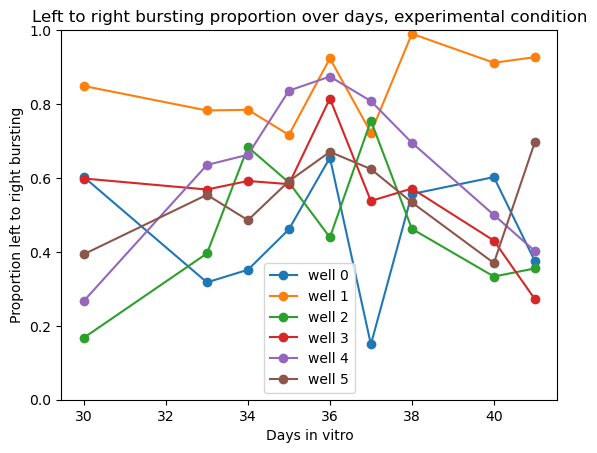

In [9]:
for well_no in range(0, 6):
    plt.plot(divs, exp_live_df.loc[(chip_id, divs, well_no), "pre live l->r"].to_numpy() / exp_live_df.loc[(chip_id, divs, well_no), "pre live total"].to_numpy(),"o-", label = f"well {well_no}")
plt.legend()
plt.title("Left to right bursting proportion over days, experimental condition")
plt.xlabel("Days in vitro")
plt.ylim([0, 1])
plt.ylabel("Proportion left to right bursting")


In [10]:


exp_differences_df = pd.DataFrame(columns = ["chip", "div", "well", "proportion change"]).set_index(["chip", "div", "well"])

for i, div in enumerate(divs[1:]):
    for well in range(0, 6):
        previous_prop =exp_live_df.loc[(chip_id, divs[i], well), "pre live l->r"] / exp_live_df.loc[(chip_id, divs[i], well), "pre live total"] 
        current_prop = exp_live_df.loc[(chip_id, div, well), "pre live l->r"] / exp_live_df.loc[(chip_id, div, well), "pre live total"]
        exp_differences_df.loc[chip_id, div,well] = (current_prop - previous_prop)/(div - divs[i])

exp_differences_df

proportion change
chip   div well                   
M07480 33  0             -0.094891
           1             -0.022057
           2              0.075965
           3             -0.009940
           4              0.122529
           5              0.053544
       34  0              0.034063
           1              0.001874
           2              0.287711
           3              0.023116
           4              0.027598
           5             -0.068741
       35  0              0.109441
           1             -0.067988
           2             -0.095666
           3             -0.008503
           4              0.173416
           5              0.105527
       36  0              0.193783
           1              0.207169
           2             -0.148626
           3              0.231481
           4              0.038165
           5              0.079418
       37  0             -0.505162
           1             -0.201083
           2              0.315715
           3             -0.277079
           4             -0.066372
           5             -0.046599
       38  0              0.406862
           1              0.267583
           2             -0.292601
           3              0.033693
           4             -0.112598
           5             -0.090276
       40  0              0.022909
           1             -0.039200
           2             -0.064516
           3             -0.070437
           4             -0.097701
           5             -0.081960
       41  0             -0.227339
           1              0.015065
           2              0.021858
           3             -0.158447
           4             -0.097884
           5              0.327232

In [11]:
exp_live_df.to_csv("counts_and_proportions_experimental.csv")
exp_differences_df.to_csv("differences_df.csv")

Text(0, 0.5, '$\\Delta$ proportion leftwards bursting, per day')

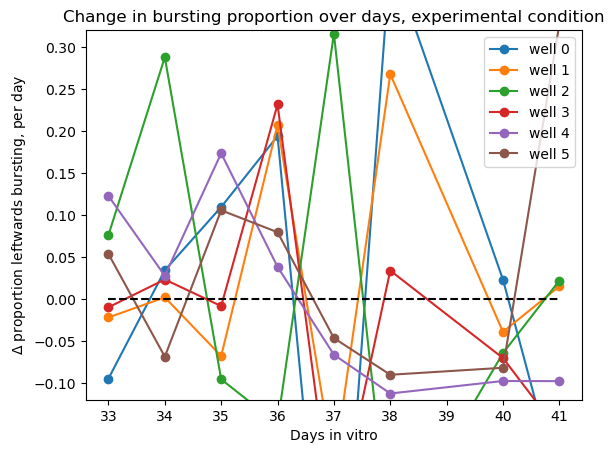

In [12]:
for well_no in range(0, 6):
    plt.plot(divs[1:], exp_differences_df.loc[(chip_id, divs[1:], well_no), "proportion change"], "o-", label = f"well {well_no}")
plt.hlines(0, divs[1], divs[-1], "k", "dashed")
plt.legend()
plt.ylim([-0.12, 0.32])
plt.title("Change in bursting proportion over days, experimental condition")
plt.xlabel("Days in vitro")
plt.ylabel("$\Delta$ proportion leftwards bursting, per day")

Text(0.5, 0, '$\\Delta$ proportion leftwards bursting, per day')

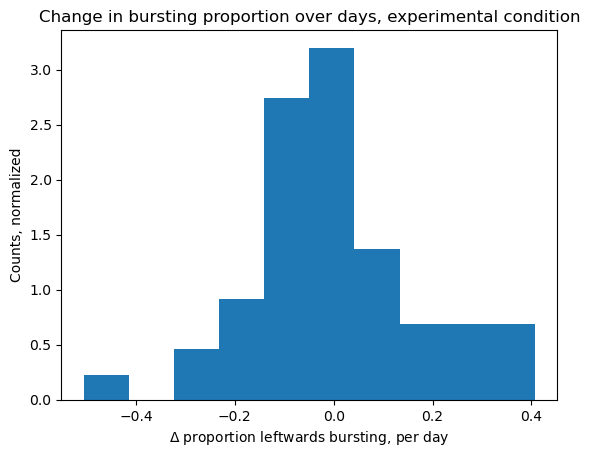

In [13]:
plt.hist(exp_differences_df["proportion change"], density = True)
plt.title("Change in bursting proportion over days, experimental condition")
plt.ylabel("Counts, normalized")
plt.xlabel("$\Delta$ proportion leftwards bursting, per day")